In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.stats import chi2
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error 
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv(r"C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\Data\reduced_data (2).csv")

label_encoders = {}
for column in df.columns[:2]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

X = df.iloc[:, :-3]
y = df.iloc[:, -2]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model2 = XGBRegressor(n_estimators= 100,random_state=100,early_stopping_rounds=10)

In [ ]:
best_params = {
    'n_estimators': 79,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 3, 
    'random_state':100
}

model3 = XGBRegressor(**best_params)
model3.fit(X_train,Y_train.values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=79, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# make predictions on the test set X_test
y_pred = model3.predict(X_test)

# prints various metrics
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean square error of the prediction set: {mse}")
rmse = np.sqrt(mse)
print(f"Root-mean-square error of the prediction set: {rmse}")
mae = mean_absolute_error(Y_test, y_pred)
print(f"Mean absolute error of the prediction set: {mae}")
r2 = r2_score(Y_test, y_pred)
print(f"R² score of the prediction set: {r2}")

# make predictions on the training set X_train
y_train_pred = model3.predict(X_train)
mse_train = mean_squared_error(Y_train, y_train_pred)
print(f"Mean square error of the training set: {mse_train}")
rmse_train = np.sqrt(mse_train)
print(f"Root mean square error of the training set: {rmse_train}")
mae_train = mean_absolute_error(Y_train, y_train_pred)
print(f"Mean absolute error of the training set: {mae_train}")
r2_train = r2_score(Y_train, y_train_pred)
print(f"R² score of the training set: {r2_train}")

In [ ]:
importances = model3.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Ranking:")
for f in range(X_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(figsize=(10, 6))
plt.title("Feature importance for predicted SCF", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), indices, fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('Importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.show()

Processing feature  Exposure time  (hrs)...
Processing feature Functional Group...
Processing feature Plant Species...


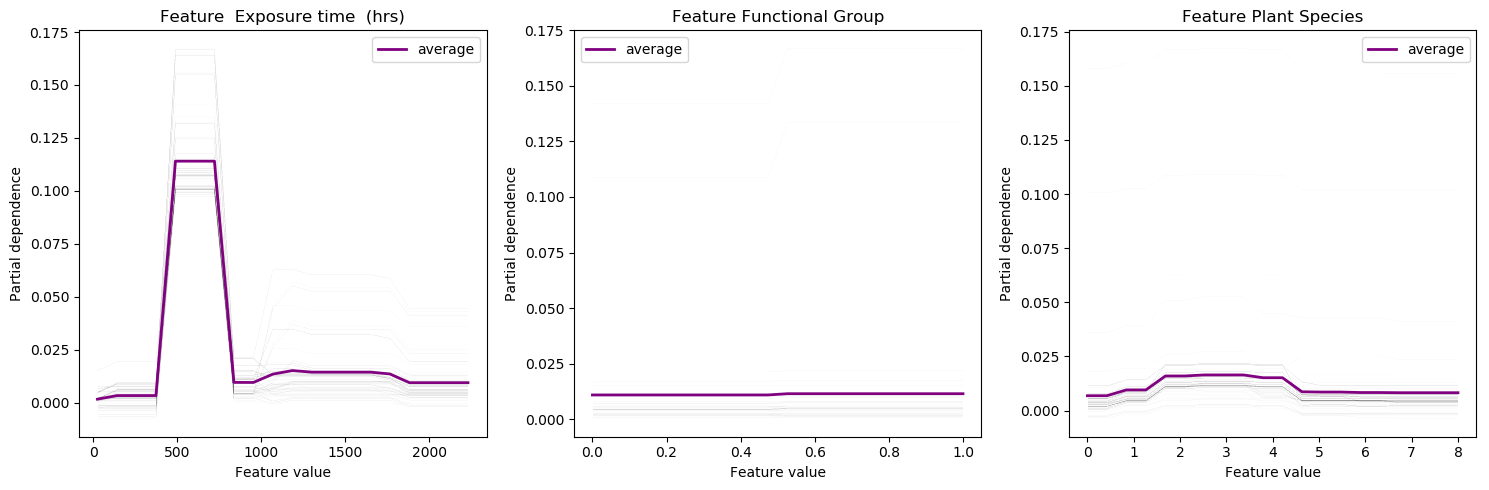

In [ ]:
# Plot Partial Dependence Plot (PDP) / Individual Conditional Expectation, ICE
from sklearn.inspection import PartialDependenceDisplay

# Select the feature indices
features = [5, 1, 0]  # Indices of the 6th, 2nd, and 1st features


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
# Loop through each feature index
for i, feature_index in enumerate(features):
    print(f"Processing feature {df.columns[feature_index]}...")

    # Create a grid of feature values
    grid = np.linspace(X.iloc[:, feature_index].min(), X.iloc[:, feature_index].max(), 20)
    
     # Calculate ICE values
    ice_values = []
    for idx, row in X.iterrows():
        ice = []
        for value in grid:
            X_temp = np.array(row).reshape(1, -1)  # Convert series to numpy array and reshape
            X_temp[0, feature_index] = value  # Assign the value to the specific feature index
            ice.append(model3.predict(X_temp)[0])
        ice_values.append(ice)
    
    # Plot ICE
    for ice in ice_values:
        axes[i].plot(grid, ice, 'purple',linewidth=0.1, alpha=0.02)
    
    # Calculate PDP values
    pdp_values = []
    for value in grid:
        X_temp = X.copy()
        X_temp.iloc[:, feature_index] = value
        pdp_values.append(model3.predict(X_temp).mean())
    pdp_values = np.array(pdp_values)
    
    # Plot PDP
    axes[i].plot(grid, pdp_values, 'purple', linewidth=2, label='average')
    
    axes[i].set_title(f'Feature {df.columns[feature_index]}')
    axes[i].set_xlabel(f'Feature value')
    axes[i].set_ylabel('Partial dependence')
    axes[i].legend()


plt.tight_layout()
plt.savefig('C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\PDP.pdf', format='pdf', bbox_inches='tight',dpi=300)
plt.show()

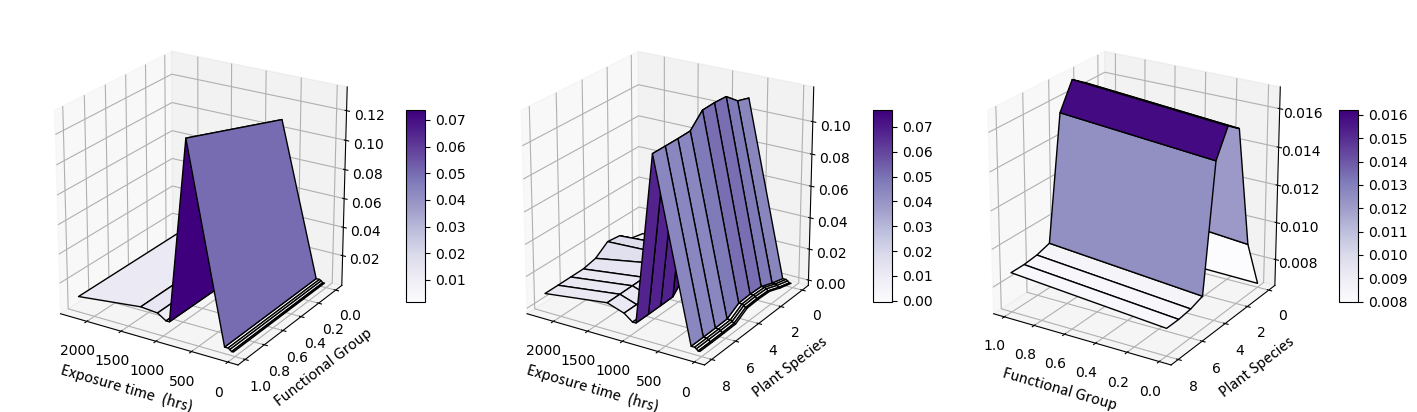

In [ ]:
from sklearn.inspection import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

# Set the feature combinations to plot, ensuring column names match exactly with X_train
feature_combinations = [
    (" Exposure time  (hrs)", "Functional Group"), 
    (" Exposure time  (hrs)", "Plant Species"),
    ("Functional Group", "Plant Species")
]

fig = plt.figure(figsize=(18, 5))
# Loop through feature combinations
for i, (feature1, feature2) in enumerate(feature_combinations):
    # Calculate partial dependence values
    pdp = partial_dependence(model3, X_train, features=[feature1, feature2], kind="average", grid_resolution=100)
    
    XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) # Create a grid of values
    Z = pdp.average[0].T # Transpose the values to match the shape of the grid
    
    # Add a 3D subplot
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Plot a 3D surface plot
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.Purples, edgecolor="k")
    
    # Set labels and view angle
    font_dict = dict(fontsize=12, family='Calibri')
    ax.set_xlabel(feature1.strip(), fontdict=font_dict)
    ax.set_ylabel(feature2, fontdict=font_dict)
    ax.view_init(elev=22, azim=122)
    
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10)


plt.subplots_adjust(wspace=0.01)
plt.savefig('C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\PDP_3D.pdf', format='pdf', bbox_inches='tight',dpi=300)
plt.show()

<Figure size 1000x1500 with 0 Axes>

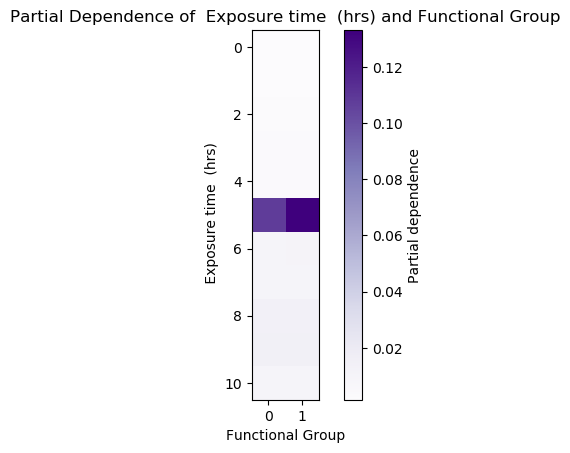

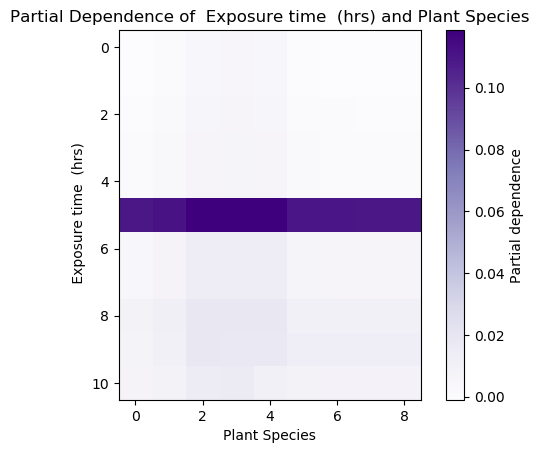

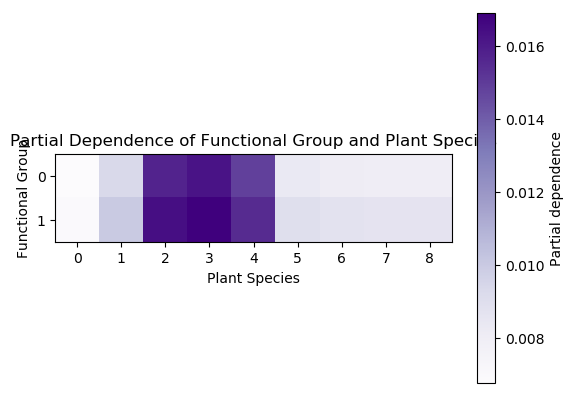

In [ ]:
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import numpy as np

feature_combinations = [
    (" Exposure time  (hrs)", "Functional Group"),
    (" Exposure time  (hrs)", "Plant Species"),
    ("Functional Group", "Plant Species")
]

fig = plt.figure(figsize=(10, 15))

for i, (feature1, feature2) in enumerate(feature_combinations):
    pdp = partial_dependence(model3, X_train, features=[feature1, feature2], kind="average", grid_resolution=100)
    
    Z = pdp.average[0]
    XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
    

    fig, ax = plt.subplots()
    cax = ax.imshow(Z, cmap='Purples', interpolation='nearest', aspect='equal')
    
    ax.set_xlabel(feature2)
    ax.set_ylabel(feature1)
    fig.colorbar(cax, ax=ax, label='Partial dependence')
    plt.title(f'Partial Dependence of {feature1} and {feature2}')
    plt.subplots_adjust(wspace=0.3)
    plt.show()